In [209]:
import torch
import numpy as np
from pathlib import Path
from cartesian_polar.exp_autoencoder.agent import Autoencoder
import random
import matplotlib.pyplot as plt
import tqdm
from environment import DuplicatedCoordsEnv
import pandas as pd
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import normalize, StandardScaler

In [210]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [211]:
save_path = Path("save")
save_path.exists()

True

In [212]:
data_dir_ew = save_path / "7-30-A-10-EW-2"
print(data_dir_ew.exists())

True


In [213]:
data_path_ew = data_dir_ew / "data.tar"
print(data_path_ew.exists())

True


In [214]:
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
data_dict_ew.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [215]:
# ASSUMING EQUAL ARCHITECTURES
parameters = data_dict_ew['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units
bottleneck = parameters.bottleneck

In [216]:
env = data_dict_ew['env'] # assuming equal environments

### Helper Functions

In [217]:
"""
Function for converting angle degree to cardinal direction
"""
def degrees_to_cardinal(degree):
    # Normalize the degree to [0, 360)
    degree = degree % 360

    # Define the mapping
    directions = {
        0: 'N',
        90: 'E',
        180: 'S',
        270: 'W'
    }

    # Find the closest cardinal angle
    closest = min(directions.keys(), key=lambda x: abs(x - degree))
    return directions[closest]

In [218]:
def convert_state_sample_to_orig_sample(state_sample):
    orig_state_samples = []
    for state in state_sample:

        if state[0].item() == 1:
            odor_cue = 'No Odor'
        elif state[1].item() == 1:
            odor_cue = 'Odor A'
        else:
            odor_cue = 'Odor B'

        coords_orig = env.conv_north_cartesian2orig(state[3:7]).tolist()
        coords_orig.insert(0, odor_cue)
        
        head_deg = coords_orig[3]
        head_cardinal = degrees_to_cardinal(head_deg)
        coords_orig[3] = head_cardinal
        
        coords_orig.append(state[3].item()) # CNP x
        coords_orig.append(state[4].item()) # CNP y
        coords_orig.append(state[7].item()) # CSP x
        coords_orig.append(state[8].item()) # CSP y

        orig_state_samples.append(coords_orig)
    return orig_state_samples

In [219]:
def get_layer_activations(net, input_states, layer_index):
    activations_list = []

    def hook(module, input, output):
        activations_list.append(output.detach().cpu().numpy().squeeze())

    # Register hook
    handle = list(net.mlp.children())[layer_index].register_forward_hook(hook)

    # Forward pass through each input state
    with torch.no_grad():
        for state in input_states:
            net(state)

    # Clean up hook
    handle.remove()

    # Stack into numpy array
    activations_array = np.stack(activations_list)  # Shape: (500, 512)

    return activations_array


In [220]:
def compute_centroids_by_category(activations, labels):
    centroids = {}
    for label in np.unique(labels):
        mask = labels == label
        centroids[label] = activations[mask].mean(axis=0)
    return centroids

## States

In [221]:
all_x = [-2, -1, 0, 1, 2]
all_y = [-2, -1, 0, 1, 2]
all_head = [0, 90, 180, 270]
all_odor = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]

all_possible_states = list(itertools.product(all_odor, all_x, all_y, all_head))

state_dicts = [
    {'cue': odor, 'x': x, 'y': y, 'direction': hd}
    for (odor, x, y, hd) in all_possible_states
]

In [222]:
all_possible_tensors = []

for state_dict in state_dicts:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_possible_tensors.append(state_tensor)

In [223]:
print(state_dicts)

[{'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': -2, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': -1, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': 0, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 90}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 180}, {'cue': tensor(0), 'x': -2, 'y': 1, 'direction': 270}, {'cue': tensor(0), 'x': -2, 'y': 2, 'direction': 0}, {'cue': tensor(0), 'x': -2, 'y': 2, 'direction': 90}, {'cue': tensor(0

In [256]:
filtered_states = [state for state in state_dicts if state['cue'] == torch.tensor(1)]
print(filtered_states)
all_filtered_tensors = []

for state_dict in filtered_states:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_filtered_tensors.append(state_tensor)
print(len(all_filtered_tensors))

[{'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': -2, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': -1, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': 0, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 90}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 180}, {'cue': tensor(1), 'x': -2, 'y': 1, 'direction': 270}, {'cue': tensor(1), 'x': -2, 'y': 2, 'direction': 0}, {'cue': tensor(1), 'x': -2, 'y': 2, 'direction': 90}, {'cue': tensor(1

## Activations

In [257]:
cat = data_dir_ew

# if cat == data_dir_lr:
#     cat_label = 'L/R'
# else:
#     cat_label = 'E/W'

model = Autoencoder(n_observations, n_actions, bottleneck, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

Autoencoder(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [258]:
state_samples = all_filtered_tensors

In [259]:
q_values = get_layer_activations(model, state_samples, 6)
chosen_actions = np.argmax(q_values, axis=1)

action_labels = ['Move Forward', 'Turn Left', 'Turn Right']
chosen_action_names = [action_labels[i] for i in chosen_actions]

In [260]:
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
print(orig_samples)

upper_triangle_coords = [(-1,2), (0,2), (1,2), (2,2), (0,1), (1,1), (2,1), (1,0), (2,0), (2,-1)]
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    "action": [],
    "triangle": [],
    "CNP x": [],
    "CNP y": [],
    "CSP x": [],
    "CSP y": []
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])
    if (state[1], state[2]) in upper_triangle_coords:
        metadata["triangle"].append('U')
    else:
        metadata["triangle"].append('L')
    metadata["CNP x"].append(state[4])
    metadata["CNP y"].append(state[5])
    metadata["CSP x"].append(state[6])
    metadata["CSP y"].append(state[7])
metadata["action"] = chosen_action_names

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

[['Odor A', -2.0, -2.0, 'N', 4.0, 4.0, 0.0, 0.0], ['Odor A', -2.0, -2.0, 'E', 4.0, 4.0, 0.0, 0.0], ['Odor A', -2.0, -2.0, 'S', 4.0, 4.0, 0.0, 0.0], ['Odor A', -2.0, -2.0, 'W', 4.0, 4.0, 0.0, 0.0], ['Odor A', -2.0, -1.0, 'N', 4.0, 3.0, 0.0, 1.0], ['Odor A', -2.0, -1.0, 'E', 4.0, 3.0, 0.0, 1.0], ['Odor A', -2.0, -1.0, 'S', 4.0, 3.0, 0.0, 1.0], ['Odor A', -2.0, -1.0, 'W', 4.0, 3.0, 0.0, 1.0], ['Odor A', -2.0, 0.0, 'N', 4.0, 2.0, 0.0, 2.0], ['Odor A', -2.0, 0.0, 'E', 4.0, 2.0, 0.0, 2.0], ['Odor A', -2.0, 0.0, 'S', 4.0, 2.0, 0.0, 2.0], ['Odor A', -2.0, 0.0, 'W', 4.0, 2.0, 0.0, 2.0], ['Odor A', -2.0, 1.0, 'N', 4.0, 1.0, 0.0, 3.0], ['Odor A', -2.0, 1.0, 'E', 4.0, 1.0, 0.0, 3.0], ['Odor A', -2.0, 1.0, 'S', 4.0, 1.0, 0.0, 3.0], ['Odor A', -2.0, 1.0, 'W', 4.0, 1.0, 0.0, 3.0], ['Odor A', -2.0, 2.0, 'N', 4.0, 0.0, 0.0, 4.0], ['Odor A', -2.0, 2.0, 'E', 4.0, 0.0, 0.0, 4.0], ['Odor A', -2.0, 2.0, 'S', 4.0, 0.0, 0.0, 4.0], ['Odor A', -2.0, 2.0, 'W', 4.0, 0.0, 0.0, 4.0], ['Odor A', -1.0, -2.0, 'N', 3.0

In [261]:
filtered_activations = get_layer_activations(model, all_filtered_tensors, 3)

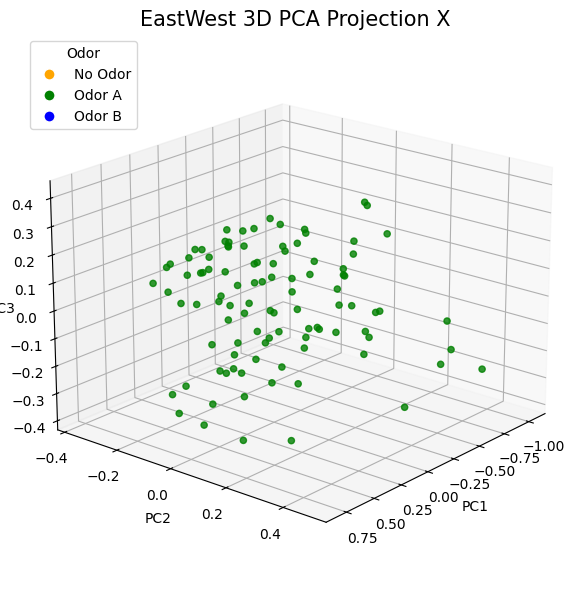

In [267]:
#Your custom label-to-color mapping
label_colors = {
    'No Odor': 'orange',
    'Odor A': 'green',
    'Odor B': 'blue'
}

# label_colors = {
#     -2: 'blue',
#     -1: 'orange',
#      0: 'green',
#      1: 'red',
#      2: 'purple'
# }

# label_colors = {
#     'N': 'blue',
#     'E': 'orange',
#     'S': 'green',
#     'W': 'red'
# }

# label_colors = {
#     'Move Forward': 'blue',
#     'Turn Left': 'orange',
#     'Turn Right': 'green'
# }

# label_colors = {
#     'L': 'red',
#     'U': 'green'
# }

colors = metadata_df['odor'].map(label_colors)

layer_activations = get_layer_activations(model, state_samples, 3)
pca = PCA(n_components=5)
pca_result = pca.fit_transform(filtered_activations)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
    c=colors,
    alpha=0.8
)

# Custom legend using same color mapping
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=8)
    for label, color in label_colors.items()
]
ax.legend(handles=legend_elements, title="Odor", loc='upper left')


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', labelpad=0.0005)
plt.title("EastWest 3D PCA Projection X", fontsize=15)
plt.subplots_adjust(left=0.9, right=1.5, bottom=0.1, top=0.9)
ax.view_init(elev=20, azim=40)  # Change angles as needed; do elev 10 azim 10 for PC3vsPC2, and play with elev 10-90
# 20/80 is good to view planes
plt.tight_layout()
#plt.savefig('figures/3DPCAEWX.png', dpi=300, bbox_inches='tight')
plt.show()

In [255]:
print(layer_activations.shape)

(25, 10)


In [231]:
explained_var = pca.explained_variance_ratio_  # list of variance per PC
cumulative_var = explained_var.cumsum()        # cumulative variance

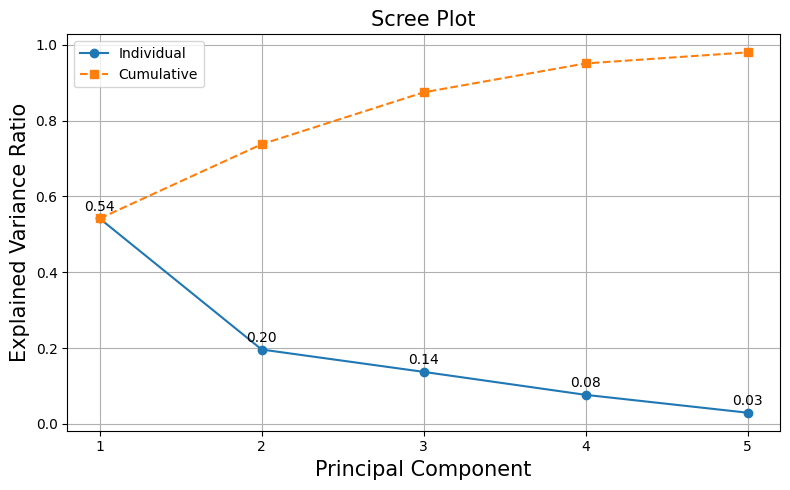

In [232]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'o-', label='Individual')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 's--', label='Cumulative')

plt.title('Scree Plot', fontsize=15)
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Explained Variance Ratio', fontsize=15)
plt.xticks(range(1, len(explained_var) + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
for i, var in enumerate(explained_var):
    plt.text(i + 1, var + 0.02, f"{var:.2f}", ha='center')
plt.savefig('figures/EWSCREE.png', dpi=300, bbox_inches = 'tight')
plt.show()

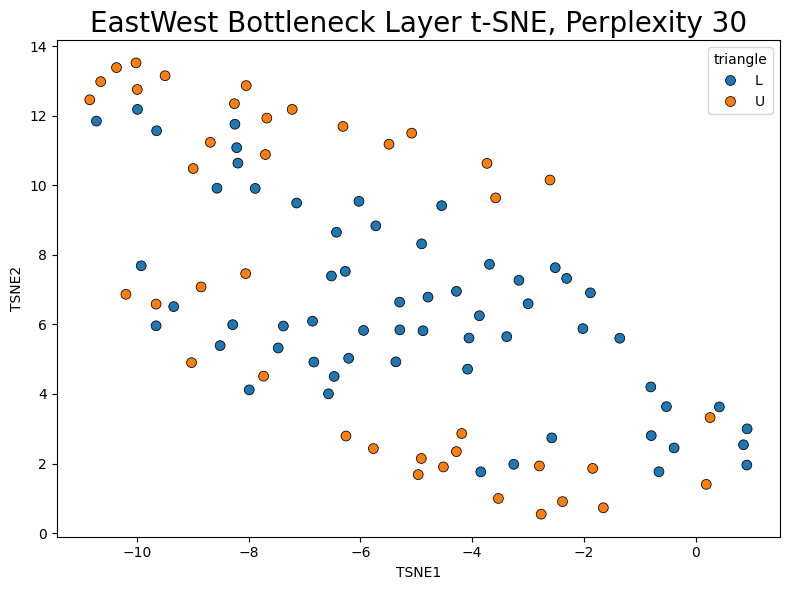

In [273]:
p=30
tsne = TSNE(n_components=2, perplexity=p, learning_rate=200, init='random', random_state=42, max_iter=5000)
activations_2d = tsne.fit_transform(layer_activations) 

tsne_df = pd.DataFrame(activations_2d, columns=["TSNE1", "TSNE2"])
full_df = pd.concat([tsne_df, metadata_df], axis=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=full_df, x="TSNE1", y="TSNE2", hue="triangle", palette="tab10",s=50,edgecolor='k')
plt.title(f"EastWest Bottleneck Layer t-SNE, Perplexity {p}", fontsize=20)
plt.tight_layout()
plt.savefig(f'figures/TSNEEWTRIANGLE.png', dpi=300, bbox_inches='tight')
plt.show()